In [1]:
import gpxpy
import pandas as pd
import numpy as np
import srtm
import matplotlib.pyplot as plt

import noaa_api_token
import strava_api_token

First, import any API tokens we need (NOAA, Strava)

In [2]:
strava = strava_api_token.strava_token
token = noaa_api_token.token


In [3]:
data_path = 'Data//'

Open the CSV file containing my activities, formatting the filename and dates in their correct formats

In [4]:
converters={'filename': lambda x: str(x)}
activities = pd.read_csv(data_path + 'activities.csv',converters=converters)
activities.date = pd.to_datetime(activities['date'])
#activities distance is in meters
#activities elapsed time is in seconds (total time, not moving time)

In [5]:
#example url to request for a zip and given start/end date
ex_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'
#example from github
ex_gh = 'https://github.com/paulokuong/noaa'

Below are some helper functions:

* **lat_lng_to_zip**
    - Translates a given latitude and longitude into the nearest US zip code
* **parse_filename**
    - Removes the .fit.gz and replaces with .gpx for files which aren't identified as .gpx in the Strava data
* **gpx_attributes**
    - Figures out the latitude and longitude of the first point within a .gpx file

In [6]:
def lat_lng_to_zip(latlng,ztc):
    minrow = (np.sqrt((ztc['LAT'] - latlng[0])**2 + (ztc['LNG'] - latlng[1])**2)).values.argmin()
    return ztc.iloc[minrow]['ZIP']

#all activities have been converted to GPX using GPSBabel, so I need to fix the filenames
def parse_filename(filename):
    filename = filename.split('/')
    if len(filename) == 1:
        filename = None
    else:
        filename = filename[1]
    
    if filename is None:
        fn = ''
    elif filename[-4:] == '.gpx':
        fn = filename
    else:
        fn = filename[:-7] + '.gpx'
    return 'Data/activities/GPX/' + fn

def gpx_attributes(filename):
    try:
        with open(filename,'r') as gpx_file:
            #gpx_file = open(filename,'r')
            gpx = gpxpy.parse(gpx_file)
            first_pt = gpx.tracks[0].segments[0].points[0]
            start_pos = (first_pt.latitude,first_pt.longitude)
        ret = start_pos
    except:
        #if there's no file then it was manually input, 
        #which means I most likely rode on my trainer at home
        ret = (40.552273, -80.044383)
    return ret

In [7]:
#load zip code data from https://gist.github.com/erichurst/7882666
converters={'ZIP': lambda x: str(x)}
ztc = pd.read_csv(data_path + 'zip_to_coord.txt',converters=converters)

In [8]:
activities['filename_fix'] = activities['filename'].apply(lambda x: parse_filename(x))
activities['latlng'] = activities['filename_fix'].apply(lambda x: gpx_attributes(x))
activities['zip'] = activities['latlng'].apply(lambda x: lat_lng_to_zip(x,ztc))

In [9]:
activities.head()

,id,date,name,type,description,elapsed_time,distance,commute,gear,filename,filename_fix,latlng,zip
0,11823912,2012-06-26 22:17:36,"Jun 26, 2012",Ride,NaN,5728,32518.2,False,NaN,activities/11823912.gpx,Data/activities/GPX/11823912.gpx,"(40.475049, -79.918379)",15206
1,12093460,2012-06-30 14:05:19,"Jun 30, 2012",Ride,NaN,6846,39051.2,False,NaN,activities/12093460.gpx,Data/activities/GPX/12093460.gpx,"(40.475199, -79.918298)",15206
2,12413019,2012-07-03 22:30:35,"Jul 3, 2012",Ride,NaN,5369,29010.3,False,Orbea,activities/12413019.gpx,Data/activities/GPX/12413019.gpx,"(40.486821, -79.894246)",15215
3,13691080,2012-07-17 22:22:28,Riverview Park,Ride,NaN,6273,37623.0,False,Orbea,activities/13691080.gpx,Data/activities/GPX/13691080.gpx,"(40.466192, -79.922708)",15206
4,14016843,2012-07-21 12:37:10,Forward Avenue,Ride,NaN,7436,36497.3,False,Orbea,activities/14016843.gpx,Data/activities/GPX/14016843.gpx,"(40.452901, -79.932796)",15232


# Nearest Stations

The NOAA API needs to have a station requested in order to be certain we get weather data. So, for each activity, we need to figure out which station was nearest to that activity

In [41]:
ghcnd_names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME']
stations_g = pd.DataFrame(columns=ghcnd_names)
all_rows = []
with open(data_path + 'ghcnd-stations.txt','r') as file:
    ind = 0
    for row in file:
        if row[0:2]!='US':
            continue
        state = row[38:40].strip()
        name = row[41:71].strip()
        t = ' '.join(row.split())
        l = t.split(' ',maxsplit=5)
        all_rows.append(l)
        #stations_g.loc[ind] = l
        #ind += 1
stations_g = pd.DataFrame(all_rows,columns=ghcnd_names)

In [56]:
numeric = ['LATITUDE','LONGITUDE','ELEVATION']
for c in numeric:
    stations_g[c] = pd.to_numeric(stations_g[c])

In [50]:
stations_i = pd.read_csv(data_path + 'isd-history.csv',quotechar='"')
stations_i = stations_i[~stations_i['LAT'].isnull()]

In [62]:
def find_nearest_station(latlng,stations):
    minrow = (np.sqrt((stations_g['LATITUDE'] - latlng[0])**2 + (stations_g['LONGITUDE'] - latlng[1])**2)).values.argmin()
    return stations_g.iloc[minrow]['ID']

In [63]:
activities['stationid'] = activities['latlng'].apply(lambda x: find_nearest_station(x,stations_g))

In [147]:
def get_noaa_data_station(url,station,header):
    url = url + station
    r = requests.get(url,headers=header)
    return r
    
def construct_params_station(token,station_id):
    creds = dict(token=token)
    station = 'GHCND:%s'%station_id
    u = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/stations/'
    r = get_noaa_data_station(u,station,creds)
    return r

In [174]:
#some stations are no longer active - need to delete these
token = noaa_api_token.token
for s in activities['stationid'].unique():
    r = construct_params_station(token,s)
    rj = r.json()
    mnd = datetime.datetime.strptime(rj['mindate'], '%Y-%m-%d')
    mxd = datetime.datetime.strptime(rj['maxdate'], '%Y-%m-%d')
    #how many are within the date range? if 0, then remove from dataset
    ct = activities[(activities['stationid']==s)&(activities['date'] > mnd)&(activities['date'] < mxd)].count()['id']
    if ct == 0:
        print("REMOVED")
        stations_g = stations_g[stations_g['ID']!=s]
        activities[(activities['stationid']==s)]['stationid'] = None
    time.sleep(0.200)
        #remove station

In [173]:
activities['stationid'] = activities['latlng'].apply(lambda x: find_nearest_station(x,stations_g))

# File Additions and Cleanup

In [9]:
#strava and weather added fields
strava_fields = [
    'athlete_count',
    'achievement_count',
    'comment_count',
    'kudos_count',
    'moving_time',
    'elapsed_time',
    'total_elevation_gain',
    'average_speed',
    'max_speed',
    'calories',
    'description'
]
weather_fields = ['TMAX','TMIN','PRECIP','stationid']
all_fields = strava_fields + weather_fields

In [10]:
for i in all_fields:
    activities[i] = None

In [11]:
fix_activities = pd.read_csv(data_path + 'activities_out.csv')

In [12]:
m = pd.merge(activities,fix_activities,left_index=True,right_on='Unnamed: 0',suffixes=['','_y'])
for i in all_fields:
    m[i].replace(np.NaN,m[i + '_y'],inplace=True)

In [13]:
activities = m.loc[:,activities.columns]

In [14]:
activities['manual'] = activities['filename_fix'].apply(lambda x: x[-4:]) == 'GPX/'

In [15]:
activities['has_station'] = ~activities['stationid'].isnull()
activities['has_weather'] = ~activities['TMAX'].isnull()
activities['has_file'] = (activities['filename'].str.len() > 0)

In [16]:
activities['indoor'] = (~activities['has_file']&((activities['gear'] == 'Trainer') | (activities['gear'] == 'Orbea')))

In [17]:
#Very few rows that are "Hike" or "Walk" - make a new column for sake of analysis to simplify
activities['new_type'] = activities['type']
activities.loc[activities['type']=='Hike','new_type'] = 'Run'
activities.loc[activities['type']=='Walk','new_type'] = 'Run'

# Strava API

In [ ]:
#https://developers.strava.com/docs/reference/#api-Activities-getActivityById

In [42]:
from stravalib.client import Client
from stravalib import unithelper

In [28]:
client = Client()
authorize_url = client.authorization_url(client_id=26961, redirect_uri='127.0.0.1')
client.access_token = strava

In [78]:
#Create new columns for all of our interesting fields above
for i in strava_fields:
    activities[i] = None

In [94]:
for ind,row in activities.iterrows():
    if not row.has_file or row.athlete_count is not None:
        continue
    try:
        activity = client.get_activity(row.id)
        if activity.resource_state != 3:
            continue
        for i in strava_fields:
            attr = getattr(activity,i)
            if i == 'total_elevation_gain':
                a = unithelper.feet(attr)
                #print(unithelper.feet(attr))
            elif i=='average_speed' or i=='max_speed':
                a = unithelper.mph(attr)
                #print(unithelper.mph(attr))
            else:
                a = attr
            activities.loc[ind,i] = a
    except:
        print('Failed')


Failed
Failed


No such attribute available_zones on entity <Activity id=1601436182 name='North Park Green Loop' resource_state=3>


# Weather

In [22]:
import datetime
import requests
import time

ex_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:28801&startdate=2010-05-01&enddate=2010-05-01'

def get_noaa_data(url,params, header):
    r = requests.get(url, params=params, headers=header)
    return r
    
def construct_params(token,station_id,start,end):
    creds = dict(token=token)
    params={}
    params['datasetid'] = 'GHCND'
    params['stationid'] = 'GHCND:%s'%station_id
    params['startdate'] = start
    params['enddate'] = end
    u = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    r = get_noaa_data(u,params,creds)
    return r

def c_to_f(c):
    return c/10.0 * 9.0/5 + 32

def get_ranges(activity,token):
    loc = activity.stationid
    #assume start and end on same day - I'm not doing any multiday touring
    start = activity.date.strftime('%Y-%m-%d')
    end = start
    try:
        weather = construct_params(token,loc,start,end)
        tmax = None
        tmin = None
        precip = None
        for res in weather.json()['results']:
            if res['datatype']=='TMAX':
                tmax = c_to_f(res['value'])
            elif res['datatype'] == 'TMIN':
                tmin = c_to_f(res['value'])
            elif res['datatype']=='PRCP':
                precip = res['value']
        retdict = {'TMAX': tmax,'TMIN':tmin,'PRECIP':precip}
    except:
        retdict = {'TMAX': None,'TMIN':None,'PRECIP':None}
    return retdict

In [216]:
for index,row in activities.iterrows():
    #already have identified the temperature for this particular row
    if not np.isnan(row['TMAX']):
        continue
    r = get_ranges(row,token)
    activities.loc[index,'TMAX'] = r['TMAX']
    activities.loc[index,'TMIN'] = r['TMIN']
    activities.loc[index,'PRECIP'] = r['PRECIP']
    time.sleep(0.200)

In [95]:
activities.to_csv(data_path + 'activities_out.csv')

In [18]:
temp = activities[activities.has_weather]
temp = temp[temp['date'].apply(lambda x: x.year) >= 2016]

In [19]:
temp.loc[:,'TAVG'] = (temp.loc[:,'TMAX'] + temp.loc[:,'TMIN'])/2
temp.loc[:,'temp_bucket'] = np.floor(temp.loc[:,'TMAX']/10) * 10

In [20]:
temp.loc[:,'dist_ft'] = temp.loc[:,'distance'] * 3.2808399
temp.loc[:,'dist_mi'] = temp.loc[:,'dist_ft'] / 5280

In [21]:
temp.groupby('temp_bucket').sum()['dist_mi']

temp_bucket
10.0    102.648098
20.0     86.596508
30.0    311.060476
40.0    409.918843
50.0    341.087972
60.0    353.178811
70.0    406.677349
80.0    531.324211
90.0    124.382854
Name: dist_mi, dtype: float64

In [22]:
from scipy.interpolate import UnivariateSpline
import math
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.preprocessing import minmax_scale

In [23]:
x = temp.date
y = temp.TMAX
ind = temp.indoor
act_type = temp.new_type

xd = np.linspace(0,1,len(x))
xs = np.linspace(0,1,len(x)*3)

x_labels = x.apply(lambda j: j.strftime('%Y-%m'))
x_labels = np.stack([xd,x_labels])

new_tick_pos = x_labels[0][range(0,len(x),math.floor(len(x)/10))]
new_tick_labels = x_labels[1][range(0,len(x),math.floor(len(x)/10))]

In [24]:
#let's size the bubbles so that each bubble is sized relative to its activity type
temp_s = temp[['new_type','distance']]
mx = temp_s.groupby('new_type').max()
temp_s = temp_s.merge(mx,left_on='new_type',right_index=True)
temp_s['s'] = temp_s['distance_x']/temp_s['distance_y']

z = minmax_scale(temp_s.s)

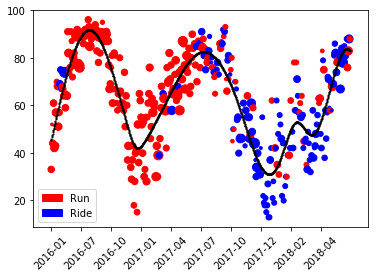

In [25]:
var_y = np.var(y)
len_y = len(y)
smoothing_factor = (var_y*len_y)*0.25

s = UnivariateSpline(xd, y,s=smoothing_factor)
ys = s(xs)

fig,ax = plt.subplots(1,1)

color_map = {True:'r',False:'b'}
color_map_act = {'Run':'r','Ride':'b'}
#colors = ind.apply(lambda x: color_map[x]).values
colors = act_type.apply(lambda x: color_map_act[x]).values
handles = []


for k,v in color_map_act.items():
    handles.append(mpatches.Patch(color=v,label=k))
    
#for k,v in color_map.items():
#    if k:
#        label = 'Indoor'
#    else:
#        label = 'Outdoor'
#    handles.append(mpatches.Patch(color=v,label=label))
    
ax.scatter(xd,y,c=colors,s=z*100)
ax.scatter(xs,ys,c='k',marker='.',s=4)
plt.xticks(new_tick_pos,new_tick_labels,rotation=45)
plt.legend(handles=handles)

plt.show()

# Heat Map

In [26]:
from folium.plugins import HeatMap
import folium
import mplleaflet

In [27]:
#Looking to plot only the activities relatively close to Pittsburgh
ll = activities['latlng'].apply(lambda x: np.array(x))
ll = ll.apply(lambda x: x-np.array((40.466192, -79.922708)))
ll = ll.apply(lambda x: np.sum(np.power(x,2)))

In [28]:
def smooth_speed(point_num,segment,num_pts_to_smooth):
    start_point = point_num - num_pts_to_smooth
    end_point = point_num + num_pts_to_smooth + 1
    if start_point < 0:
        start_point = 0
    if end_point > len(segment.points):
        end_point = len(segment.points)
    n = end_point - start_point
    
    avg = 0
    for i in range(start_point,end_point - 1):
        cur_pt = segment.points[i]
        next_pt = segment.points[i+1]
        avg += cur_pt.speed_between(next_pt)
    return avg / n

In [29]:
def plot_activity(activity):
    fn = activity.filename_fix
    with open(fn,'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
        lat = []
        lng = []
        segment = gpx.tracks[0].segments[0]
        for point_no, pt in enumerate(segment.points):
            lat.append(pt.latitude)
            lng.append(pt.longitude)
    #plt.plot(lng, lat, color = 'deepskyblue', lw = 0.2, alpha = 0.8)
    return lat,lng

In [30]:
#Puts them into a list of lists
#activities_subset = activities[(activities['manual']==False)]
activities_subset = activities[(ll < 0.5)&(activities['manual']==False)]

all_lat = []
all_lng = []
act_type = []
for ind,row in activities_subset.iterrows():
    lat,lng = plot_activity(row)
    act_type.append(row.new_type)
    all_lat.append(lat)
    all_lng.append(lng)

In [31]:
fig = plt.figure(facecolor = '0.05',figsize=(20,20))
ax = plt.Axes(fig, [0., 0., 1., 1.], )
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)
for i in range(len(all_lat)):
    lat = all_lat[i]
    lng = all_lng[i]
    a = act_type[i]
    if a=='Ride':
        plot_col = 'red'
    else:
        plot_col = 'blue'
    plt.plot(lng,lat, color = plot_col, lw = 2, alpha = 0.2)
mplleaflet.show(tiles='cartodb_positron')

# Trying to Use Quiver

In [44]:
import pyproj

In [45]:
fn = activities_subset.loc[0].filename_fix
with open(fn,'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [52]:
seg = gpx.tracks[0].segments[0]

In [99]:
y = [pt.latitude for pt in seg.points]
x = [pt.longitude for pt in seg.points]
speed = [seg.get_speed(i) for i in range(len(seg.points))]
speed = np.array(speed)

In [56]:
proj_in = pyproj.Proj(preserve_units=True, init='epsg:4326', no_defs=True)
crs_out = {'init': 'epsg:26986', 'no_defs': True}
proj_out = pyproj.Proj(preserve_units=True, **crs_out)
t = pyproj.transform(proj_in, proj_out, x, y)

In [93]:
from math import radians, degrees,cos, sin, asin, sqrt, atan2

def bearing(pt_one, pt_two):
    lat1, lon1 = map(radians,pt_one)
    lat2, lon2 = map(radians,pt_two)
    
    dL = lon2 - lon1
    x = cos(lat2) * sin(dL)
    y = cos(lat1) * sin(lat2) - sin(lat1) * cos(lat2) * cos(dL)
    b = atan2(x,y)
    return b

In [110]:
#Calculating bearing between two points
pt_one=[39.099912, -94.581213]
pt_two=[38.627089, -90.200203]

h = bearing(pt_one,pt_two)

In [100]:
bearings = []
for i in range(len(y)):
    pt_one = [y[i],x[i]]
    try:
        pt_two = [y[i+1],x[i+1]]
    except:
        pt_two = pt_one
    bearings.append(bearing(pt_one,pt_two))
bearings = np.array(bearings)

In [115]:
r = speed / max(speed)
uv = r[:, np.newaxis] * np.column_stack([np.sin(bearings), np.cos(bearings)])

In [128]:
mapfile = 'strava_quiver.html'

plt.quiver(x, y, uv[:,0], uv[:,1], speed,scale=20)
mplleaflet.show(path=mapfile,tiles='cartodb_positron')

# Speed and Smoothing

In [48]:
pt = []
x = []
smoothed_x = []

for track in gpx.tracks:
    for segment in track.segments:
        for point_no, point in enumerate(segment.points):
            pt.append(point_no)
            x.append(point.speed_between(segment.points[point_no - 1]))
            smoothed_x.append(smooth_speed(point_no,segment,5))
#             print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

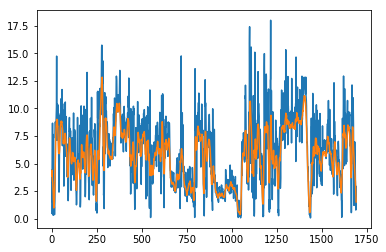

In [49]:
plt.plot(pt,x)
plt.plot(pt,smoothed_x)
plt.show()

# Strava Attributes

In [ ]:
activities.groupby('')